In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from pathlib import Path

from utils.data import get_dataset_iterator

import torch
from torch import nn

from utils.dl import QuantGAN_TemporalBlock

data_path = Path("data")
models_dir = Path("models")

hsm_dataset_path = data_path / "huge_stock_market_dataset"
solar_energy_dataset_path = data_path / "solar_energy"
fuel_prices_dataset_path = data_path / "fuel_prices"
passengers_dataset_path = data_path / "air_passengers"

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [2]:
# 3rd version (5, 256, 32) + high freq preprocessing + new gen
def is_high_freq(time_series, threshold=0.85, rolling_parts=200):
    orig_std = time_series.std().values[0]
    ma_ts = time_series.rolling(len(time_series) // rolling_parts).mean()
    ma_std = ma_ts.std().values[0]
    return abs(ma_std - orig_std) / orig_std > threshold

def ma(time_series, rolling_parts=200, window=None):
    if window is None:
        window = max(len(time_series) // rolling_parts, 2)
    ts1 = time_series.rolling(window, closed="left").mean()
    ts2 = time_series[:: - 1].rolling(window).mean()[:: - 1]
    ts1[ts1.isna()] = ts2[ts1.isna()]
    ts2[ts2.isna()] = ts1[ts2.isna()]
    ats = (ts1 + ts2) / 2
    return ats


class TimeDIffusion(nn.Module):
    def __init__(self):
        super().__init__()
        self.tcn = nn.ModuleList([QuantGAN_TemporalBlock(1, 128, kernel_size=1, stride=1, dilation=1, padding=0, dropout=0.25),
                                 *[QuantGAN_TemporalBlock(128, 128, kernel_size=2, stride=1, dilation=i, padding=i, dropout=0.0)
                                        for i in [2 ** i for i in range(14)]]])
        self.last = nn.Conv1d(128, 1, kernel_size=1, stride=1, dilation=1)

    def forward(self, x):
        skip_layers = []
        for layer in self.tcn:
            skip, x = layer(x)
            skip_layers.append(skip)
        x = self.last(x + sum(skip_layers))
        return x


epochs = 20
steps_per_epoch = 32
samples_to_gen = 20
steps_to_gen = set(range(3, 3 + samples_to_gen))
max_gen_step = max(steps_to_gen) + 1
batch_size = 32

5 min 1k ts

noise thresholds (steps): 1.4 (25/256), 0.9 (41/256), 0.68 (15/256), 0.04 (98/256), 0.55 (65/256)

In [4]:
model = TimeDIffusion()
model.load_state_dict(torch.load("models/hsm/model1.pt"))

<All keys matched successfully>

In [7]:
model.cuda()

TimeDIffusion(
  (tcn): ModuleList(
    (0): QuantGAN_TemporalBlock(
      (conv1): Conv1d(1, 128, kernel_size=(1,), stride=(1,))
      (chomp1): Chomp1d()
      (relu1): ReLU()
      (dropout1): Dropout(p=0.25, inplace=False)
      (conv2): Conv1d(128, 128, kernel_size=(1,), stride=(1,))
      (chomp2): Chomp1d()
      (relu2): ReLU()
      (dropout2): Dropout(p=0.25, inplace=False)
      (net): Sequential(
        (0): Conv1d(1, 128, kernel_size=(1,), stride=(1,))
        (1): ReLU()
        (2): Dropout(p=0.25, inplace=False)
        (3): Conv1d(128, 128, kernel_size=(1,), stride=(1,))
        (4): ReLU()
        (5): Dropout(p=0.25, inplace=False)
      )
      (downsample): Conv1d(1, 128, kernel_size=(1,), stride=(1,))
      (relu): ReLU()
    )
    (1): QuantGAN_TemporalBlock(
      (conv1): Conv1d(128, 128, kernel_size=(2,), stride=(1,), padding=(1,))
      (chomp1): Chomp1d()
      (relu1): ReLU()
      (dropout1): Dropout(p=0.0, inplace=False)
      (conv2): Conv1d(128, 128, k

In [5]:
iterator = get_dataset_iterator("hsm", hsm_dataset_path)
next(iterator)
time_series = next(iterator)
train = time_series.values.flatten()
tmean = train.mean()
tstd = train.std()
train = (train - tmean) / tstd

In [9]:
from utils.synth_eval import kl_div

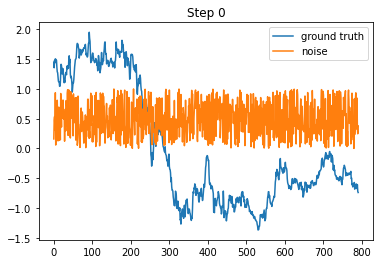

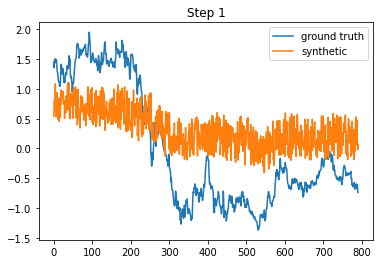

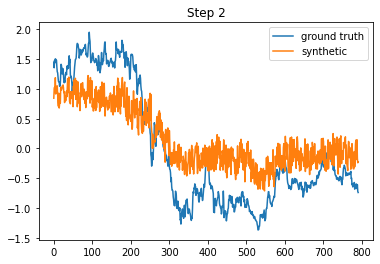

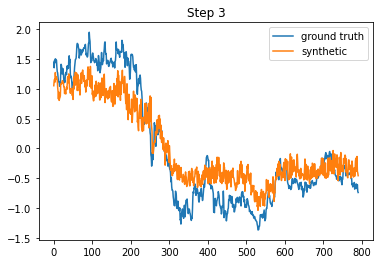

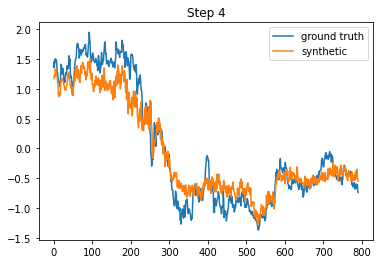

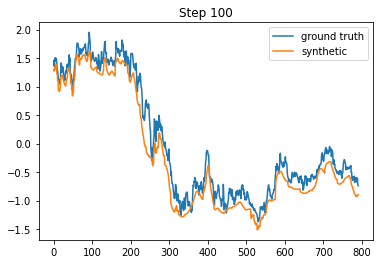

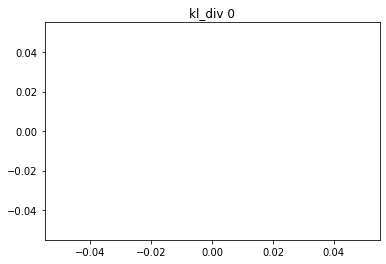

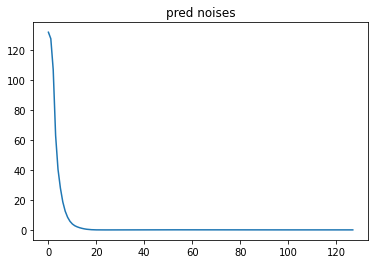

inf 132.115966796875


In [15]:
steps = steps_per_epoch // 2
plot_rate = steps // 5
with torch.no_grad():
    model.eval()
    noise = torch.rand(1, 1, len(train)).to(device)
    generated = noise
    plt.plot(train)
    plt.plot(generated.detach().cpu().squeeze().numpy())
    plt.legend(["ground truth", "noise"])
    plt.title(f"Step {0}")
    plt.show()
    kl_divs = []
    pred_noises = []
    for step in range(1, steps + 1):
        pred_noise = model(generated)
        generated -= pred_noise
        
        pred_noises.append(pred_noise.sum().item())
        kl_divs.append(kl_div(generated.detach().cpu().squeeze().numpy(), train).mean())
        
        if step  in range(5) or step == 100:

            result = generated.detach().cpu().squeeze().numpy()
            plt.plot(train)
            plt.plot(result)
            plt.legend(["ground truth", "synthetic"])
            # plt.title(f"Step #{step} pred_noise: {pred_noises[- 1]:0.4f} kl_div: {kl_divs[- 1]: 0.4f}")
            plt.title(f"Step {step}")
            plt.show()
    
    plt.plot(range(len(kl_divs)), kl_divs)
    ind = np.argmin(kl_divs)
    plt.title("kl_div " + str(ind))
    plt.show()
    plt.plot(range(len(pred_noises)), pred_noises)
    plt.title("pred noises")
    plt.show()
    print(kl_divs[ind], pred_noises[ind])
# plt.plot(noise.cpu().numpy().squeeze())
# plt.plot(pred_noise.cpu().numpy().squeeze())
# plt.legend(["noise", "pred_noise"])

In [ ]:
dataset = None
for time_series in dataset:
    ts_index += 1
    
    # high freq check
    if is_high_freq(time_series):
        time_series = ma(time_series)
    
    train = time_series.values.flatten()
    tmean = train.mean()
    tstd = train.std()
    train = (train - tmean) / tstd
    train_tensor = torch.from_numpy(train).float().to(device)

    torch.random.manual_seed(0)
    model = TimeDIffusion().to(device)
    optim = torch.optim.AdamW(model.parameters(), lr=4e-4)
    generate_noise = lambda x: x
    num_epochs = epochs

    for epoch in range(num_epochs):
        X = train_tensor.repeat(batch_size, 1).unsqueeze(1)
        noise = generate_noise(X.shape).to(device)
        noise_level = torch.rand(X.shape).to(device)
        noise *= noise_level

        for step in range(steps_per_epoch):
            optim.zero_grad()

            predicted_noise = model(X + noise)
            loss = (noise - predicted_noise).abs().mean()
            loss.backward()
            optim.step()
            with torch.no_grad():
                noise -= predicted_noise

    model.eval()
    result = []
    steps_to_generate = steps_per_epoch // 2

    with torch.no_grad():

        new_samples = generate_noise(X.shape)
        for step in range(steps_per_epoch):
            predicted_noise = model(new_samples)
            new_samples -= predicted_noise
            if step in steps_to_gen:
                result.append(new_samples)

    result = np.row_stack(result)
    
#         break
#     break